# **Data Preparation and Modelling**

## Objectives

- Developing a solution for Business Requirement No. 2:   
The client seeks to determine the specific variety of rice depicted in the uploaded images.

## Inputs

- Images are taken from the test, train, validation folders and their subfolders.  

         .
         ├── inputs   
         │   └──datasets_devided
         │      └──rice  
         │           ├── test  
         │           │   ├── Arborio  
         │           │   ├── Basmati  
         │           │   ├── Ipsala  
         │           │   ├── Jasmine 
         │           │   └── Karacadag
         │           ├── train
         │           │   ├── Arborio  
         │           │   ├── Basmati  
         │           │   ├── Ipsala  
         │           │   ├── Jasmine  
         │           │   └── Karacadag
         │           └── validation
         │               ├── Arborio  
         │               ├── Basmati  
         │               ├── Ipsala  
         │               ├── Jasmine  
         │               └── Karacadag  
         └── ...

## Outputs  

?????????

---

# Change working directory

We store our Jupyter notebooks in a subfolder of the project. Therefore, when we run the notebooks in the editor, we need to change the working directory. This is necessary to ensure proper access to data files and other project resources that might be located outside the notebook's subfolder.

We need to change the working directory from its current folder to its parent folder

- To access the current working directory, we use the os.getcwd() command. 

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Rice-Detector/jupyter_notebooks'

Then, we change the working directory from its current folder to its parent folder to facilitate the correct file path references within our notebooks.

- os.path.dirname() gets the parent directory
- os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Rice-Detector'

---

# Image data augmentation

### Augmentation parameters

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt

# Augmentation parameters
augmented_image_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)



2023-12-30 21:16:56.973745: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data augmentation can be applied to all machine learning datasets, including validation and test sets, especially in cases of insufficient data volume. However, as a rule, data augmentation is applied only to the training set, not to the validation or test set. This is because data augmentation can lead to model overfitting if it is applied to the validation or test set. In our case, there is a sufficient volume of data. Therefore, we will apply augmentation only to the training set.

### Augment training image set

In [5]:
# Batch size
batch_size = 16

# Path to the training dataset
train_path = 'inputs/datasets_devided/train'

# Specifying image size
image_shape = (224, 224, 3)  

# Augmenting the training dataset
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],  # Only the width and height are needed here
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Displaying the classes
print(train_set.class_indices)


Found 52500 images belonging to 5 classes.
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


### Plot augmented training image set

(16, 224, 224, 3)


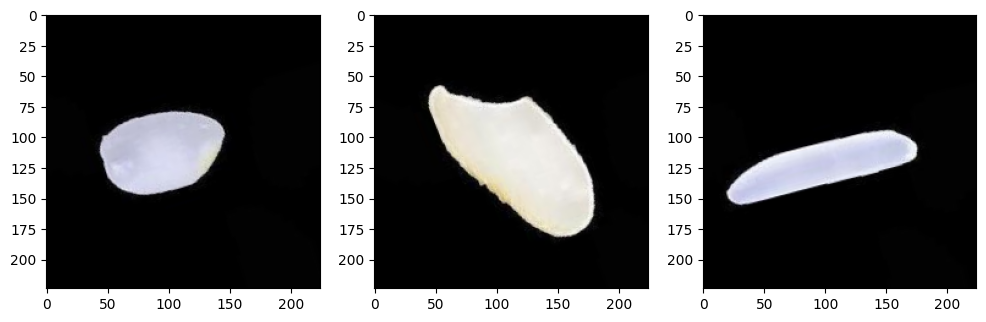

(16, 224, 224, 3)


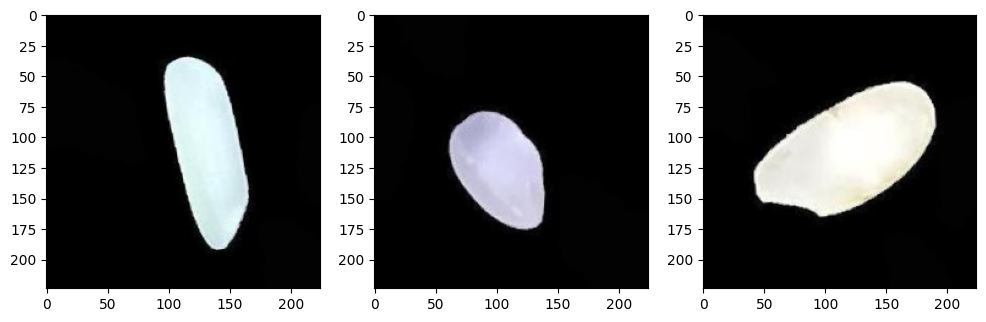

(16, 224, 224, 3)


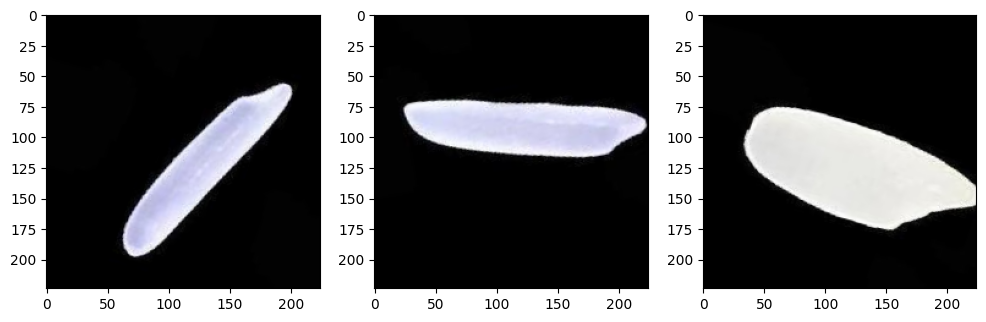

In [6]:
# Displaying augmented images
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(12, 4))
    img, label = train_set.next()
    print(img.shape)  
    for i in range(3):  # Displaying 3 images from the batch
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[i])
    plt.show()

### Save class_indices

In [7]:
import joblib

# Path to directory for saving files
file_path = 'outputs/v1'

# Save class indices from the training set
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

# Print message confirming successful saving
print(f"Class indices saved to {file_path}/class_indices.pkl")

Class indices saved to outputs/v1/class_indices.pkl


---

# Model Creation

### Model

In this model:

Three convolutional layers (Conv2D) are used, followed by pooling layers (MaxPooling2D).
A Flatten layer is applied to transform the two-dimensional convolutional layers into a one-dimensional vector.
A fully connected layer (Dense) with 64 neurons is introduced.
A Dropout layer is used to reduce the risk of overfitting.
The final Dense layer is set up with 5 neurons, corresponding to the 5 classes of rice varieties, with a softmax activation function for multi-class classification.
The model is compiled with the Adam optimizer and the categorical_crossentropy loss function, which is typical for multi-class classification tasks.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def create_tf_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening the layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer (5 classes for 5 types of rice)
    model.add(Dense(5, activation='softmax')) 

    # Compiling the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return model

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/rice_model.keras', monitor='val_accuracy', mode='max', save_best_only=True)

# Create and summarize the model
model = create_tf_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

### Fit model for training

In [9]:
# Creating the model
model = create_tf_model()

# Paths to training and validation datasets
train_path = 'inputs/datasets_devided/train'
validation_path = 'inputs/datasets_devided/validation'

# Using the same ImageDataGenerator for training data
train_datagen = augmented_image_data
# No augmentation is required for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators for training and validation
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_set = validation_datagen.flow_from_directory(
    validation_path,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Training the model
model.fit(
    train_set,
    epochs=32,
    steps_per_epoch=len(train_set.classes) // batch_size,
    validation_data=validation_set,
    callbacks=[early_stop, m_checkpoint],
    verbose=1
)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Epoch 1/32
3281/3281 [==============================] - 1503s 458ms/step - loss: 0.3247 - accuracy: 0.8760 - val_loss: 0.0916 - val_accuracy: 0.9756
Epoch 2/32
3281/3281 [==============================] - 1551s 473ms/step - loss: 0.1421 - accuracy: 0.9512 - val_loss: 0.0334 - val_accuracy: 0.9882
Epoch 3/32
3281/3281 [==============================] - 1388s 423ms/step - loss: 0.0980 - accuracy: 0.9671 - val_loss: 0.0470 - val_accuracy: 0.9831
Epoch 4/32
3281/3281 [==============================] - 1508s 460ms/step - loss: 0.0827 - accuracy: 0.9727 - val_loss: 0.0310 - val_accuracy: 0.9881
Epoch 5/32
3281/3281 [==============================] - 1726s 526ms/step - loss: 0.0783 - accuracy: 0.9741 - val_loss: 0.0722 - val_accuracy: 0.9772
Epoch 6/32
3281/3281 [==============================] - 1572s 479ms/step - loss: 0.0741 - accuracy: 0.9767 - val_loss: 0.0629 - val_accuracy: 0.9812
Epoch 6: early stopp

In [10]:
from keras.models import load_model
model.save('outputs/v1/current_model_state.keras')